In [1]:
import pylevin as levin
import numpy as np
import time
import matplotlib.pyplot as plt

# Integral over a single Bessel function tutorial and comparison

Let us define an integral of the type
$$ I(k,y) = \int_a^b j_\ell(xk) f(x,y) \mathrm{d}x\,, $$
which we integrate from $x=10^{-5}$ to $100$. For the function we assume $f(x) = x^{3y} + x^2 + x$. For different values of $y$. We first define the integrand so that it has the shape ``(len(x),N)``.

In [2]:
x_length = 100
N = 2
x = np.geomspace(1e-5,100,x_length) #define support
y = np.linspace(1,2, N) 
f_of_x = x[:,None]**(3*y[None,:]) + (x**2 +x)[:, None] #define integrands f(x) 

Next, we set up the levin class for the case ``0``, because we are interested in integrals over a single spherical Bessel function. Since our integrand is a power law, it is useful to interpolate double logarithmically, so we set ``logx = True`` and ``logy = True``. Lastly, we initialise the class by calling ``levin.pylevin``.

In [3]:
integral_type = 0 
N_thread = 1 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
lp_single = levin.pylevin(integral_type, x, f_of_x, logx, logy, N_thread) #Constructor of the class

n_sub = 10 #number of collocation points in each bisection
n_bisec_max = 32 #maximum number of bisections used
rel_acc = 1e-4 #relative accuracy target
boost_bessel = True #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?
lp_single.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)

We have now initiated the levin class and the spline for the integrand is set as well as the integral type, which we choose to be the one displayed on top (the type cannot be changed in the same instance of levinpower). The code checks internally if a logarithmic spline can be created, i.e. if $f(x)$ is positive everywhere. If this is not the case the code falls back to a linear spline. 

Note that we simply pretend to have many integrands $f(x)$ we of the integral type above by broadcasting. In prinicple, the code simply expects the support `x` and the integrand `f_of_x` which should have shape `(len(x),#number integrands)`. Pay attention that the second dimension always must be around even for a single integrand. So you could for example pass `x` and `f_of_x[:, None]`, if `f_of_x` is a simple 1d array.

We can plot the integrand if we like by calling `get_integrand(x)`, which returns a list, castable to an array, of shape `(len(x), N)`. The dashed lines show the input integrand and the solid lines the integrand returned from levin.

Text(0, 0.5, 'integrand')

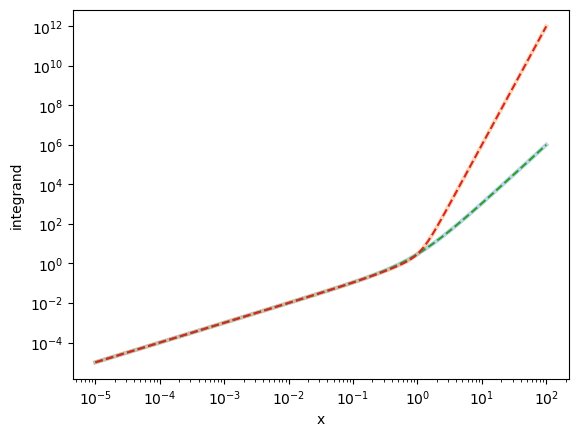

In [4]:
integrand = np.array(lp_single.get_integrand(x))
fig, ax = plt.subplots()
ax.loglog(x, integrand, alpha = .3, lw = 3)
ax.loglog(x, f_of_x, ls = "--")
ax.set_xlabel("x")
ax.set_ylabel("integrand")

We now define the arguments `k` and `ell` at which the integrals are to be evaluated as well as the lower and upper integration bound. These all have to be one-dimensional arrays of the same size `M`. 
Importantly, we have to create the `result` array of the correct shape. It has to have shape `(M,N)`, i.e. the number of arguments and the number of integrands.

Lastly, the variable `diagonal` simply specifies if only the diagonal terms of `(M,N)` matrix should be calculated. Setting it to `True` only works of `M = N`. In this case, `result` must also be a simple one-dimensional array of size `N`.

In [5]:
M = 1000 #number of arguments at which the integrals are evaluated
k = np.geomspace(1e-3,1e4,M)
ell = (5*np.ones_like(k)).astype(int) #order of the Bessel function, needs to be an integer
t0 = time.time()
result_levin = np.zeros((M, N)) #allocate the result
lp_single.levin_integrate_bessel_single(x[0]*np.ones_like(k), x[-1]*np.ones_like(k), k, ell, result_levin)
print("Levin took", time.time() -t0, "s")



Levin took 0.04005098342895508 s


Next, we can compare the result from levin to a normal (adaptive) quadrature integration. We plot the integral for the first integrand times `k` to highlight the large frequency behaviour. It can be seen that both methods agree well up to $k\approx 1$. For larger values, however, the quadrature integration breaks down completely. Furthermore, the Levin method was roughly **100 times faster**. To level the playing ground, we did not use hyperthreading in both cases and required the same relative accuracy to be reached.

/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/1224832065.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/1224832065.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]


Quadrature took 2.224414110183716 s


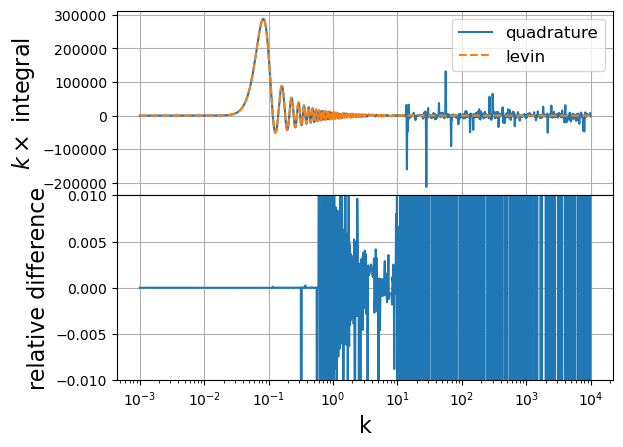

In [6]:
from scipy.special import spherical_jn, jv
from scipy import integrate


quad_result = np.zeros_like(result_levin)

t0 = time.time()
for k_i, k_val in enumerate(k):
    for i_integral in range(N):
        integrand_quad = lambda xquad: ((xquad**(3*y[i_integral]) + xquad**2 + xquad)*spherical_jn(ell[0],k_val*xquad))
        quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
print("Quadrature took", time.time() -t0, "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,quad_result[:,0]*k, label = r"quadrature")
ax[0].semilogx(k,result_levin[:,0]*k, ls = "--", label = r"levin")
ax[0].set_ylabel(r"$k \times$ integral", fontsize = 16)
ax[0].grid(axis = "both")
ax[0].legend(fontsize = 12)


ax[1].semilogx(k, (quad_result[:,0] - result_levin[:,0])/result_levin[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-.01,.01)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)


The story does not end here though, we can now update the integrand in levin if the rest of the integral stays the same, i.e. we just update $f(x,y)$. If we now reevaluate the integral, it uses the bisection which was already defined before. If the functional form of $f(x,y)$ changes too much, defined bisection will not be correct and one would have to create a new instance of levin (as done above). However, for almost all inference problems, where $f(x,y)$ only differs by a little, we can reuse the instantiated class.

We again compare the result again against a quadrature and see a similar storyline as before, but the levin method was even faster. 

Levin took 0.03337597846984863 s


/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/3617940320.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/3617940320.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]


Quadrature took 2.3832077980041504 s


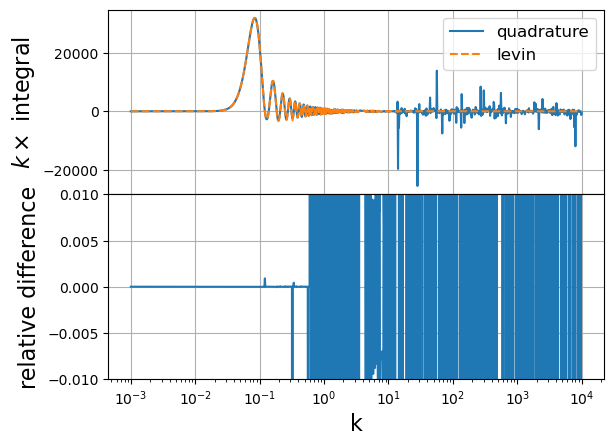

In [7]:
f_of_x = x[:,None]**(2.5*y[None,:]) + (x**1.5 +x)[:, None] #define integrands f(x) 

t0 = time.time()
lp_single.update_integrand(x,f_of_x, logx, logy)
lp_single.levin_integrate_bessel_single(x[0]*np.ones_like(k), x[-1]*np.ones_like(k), k, ell, result_levin)
print("Levin took", time.time() -t0, "s")

t0 = time.time()
for k_i, k_val in enumerate(k):
    for i_integral in range(N):
        integrand_quad = lambda xquad: ((xquad**(2.5*y[i_integral]) + xquad**1.5 + xquad)*spherical_jn(ell[0],k_val*xquad))
        quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
print("Quadrature took", time.time() -t0, "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,quad_result[:,0]*k, label = r"quadrature")
ax[0].semilogx(k,result_levin[:,0]*k, ls = "--", label = r"levin")
ax[0].set_ylabel(r"$k \times$ integral", fontsize = 16)
ax[0].grid(axis = "both")
ax[0].legend(fontsize = 12)

ax[1].semilogx(k, (quad_result[:,0] - result_levin[:,0])/result_levin[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-.01,.01)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)




We now update the integrand again. What happens if you run levin in the same instance twice is that it not only sets the bisection but also has the linear system of equations solved (up to the inhomogeneity), which is given by $f(x,y)$. Therefore the integration simply amounts to matrix multiplications summing up the results from the different bisections.

From this, we obtain the largest speed-up of levin and it is now **1000** times faster than the quadrature. Note that this is a lower bound on the improvement and that the quadrature completely fails and high frequencies.



Levin took 0.006540060043334961 s


/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/680102011.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/680102011.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]


Quadrature took 2.327159881591797 s


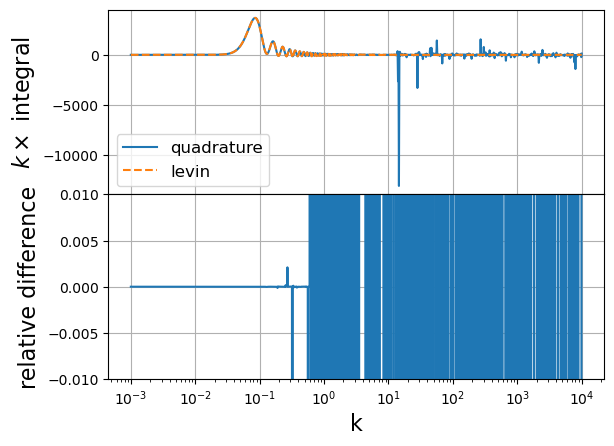

In [8]:
f_of_x = x[:,None]**(2*y[None,:]) + (x**1.1 +x)[:, None] #define integrands f(x) 

t0 = time.time()
lp_single.update_integrand(x,f_of_x, logx, logy)
lp_single.levin_integrate_bessel_single(x[0]*np.ones_like(k), x[-1]*np.ones_like(k), k, ell, result_levin)
print("Levin took", time.time() -t0, "s")

t0 = time.time()
for k_i, k_val in enumerate(k):
    for i_integral in range(N):
        integrand_quad = lambda xquad: ((xquad**(2.*y[i_integral]) + xquad**1.1 + xquad)*spherical_jn(ell[0],k_val*xquad))
        quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
print("Quadrature took", time.time() -t0, "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,quad_result[:,0]*k, label = r"quadrature")
ax[0].semilogx(k,result_levin[:,0]*k, ls = "--", label = r"levin")
ax[0].set_ylabel(r"$k \times$ integral", fontsize = 16)
ax[0].grid(axis = "both")
ax[0].legend(fontsize = 12)

ax[1].semilogx(k, (quad_result[:,0] - result_levin[:,0])/result_levin[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-.01,.01)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)




# Integral over a product of two Bessel functions

Let us define an integral of the type
$$ I(k_1,k_2,\ell_1,\ell_2,y) = \int j_{\ell_1}(xk_1)j_{\ell_2}(xk_2) f(x,y) \mathrm{d}x\,, $$

which we integrate from $x=10^{-5}$ to $100$. For the function we assume $f(x) = x^{3y} + x^2 + x$. For different values of $y$. We first define the integrand so that it has the shape ``(len(x),N)``. We follow the steps described above in the example for the single Bessel function. We do not update the integrand though, however, you can expect at a reduction of a factor 10 in runtime when updating the integrand as before.

Furthermore, we also use the `set_levin` function, which allows to play with the parameters of the code. Note, that this should be set before the first time calculating the integral for a given instance and must not be changed after.

We see the same behaviour as in the case of a single Bessel function, namely that Levin is way faster (at least two orders) and more accurate, especially at high frequencies, where the quadrature completely fails.

Levin took 0.20630288124084473 s


/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/931471421.py:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/931471421.py:33: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]


Quadrature took 4.163581848144531 s


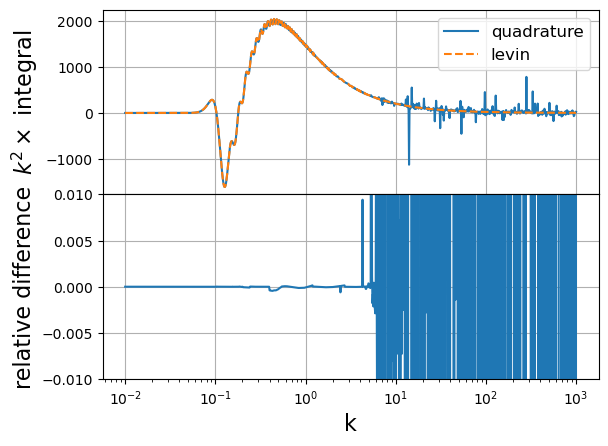

In [10]:
x_length = 100
N = 2
x = np.geomspace(1e-5,100,x_length) #define support
f_of_x = x[:,None]**(3*y[None,:]) + (x**2 +x)[:, None] #define integrands f(x) 

integral_type = 2
N_thread = 1 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
lp_double = levin.pylevin(integral_type, x, f_of_x, logx, logy, N_thread) #Constructor of the class

n_sub = 6 #number of collocation points in each bisection
n_bisec_max = 32 #maximum number of bisections used
rel_acc = 1e-4 #relative accuracy target
boost_bessel = True #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = True #should the code talk to you?
lp_double.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)

M = 1000
k = np.geomspace(1e-2,1000,M)
ell_1 = (5*np.ones_like(k)).astype(int)
ell_2 = (10*np.ones_like(k)).astype(int)

t0 = time.time()
lp_double.levin_integrate_bessel_double(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,ell_1,ell_2, result_levin)
print("Levin took", time.time() -t0, "s")


t0 = time.time()
for k_i, k_val in enumerate(k):
    for i_integral in range(N):
        integrand_quad = lambda xquad: ((xquad**(3*y[i_integral]) + xquad**2 + xquad)*spherical_jn(ell_1[0],k_val*xquad) * spherical_jn(ell_2[0],k_val*xquad))
        quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
print("Quadrature took", time.time() -t0, "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,quad_result[:,0]*k**2, label = r"quadrature")
ax[0].semilogx(k,result_levin[:,0]*k**2, ls = "--", label = r"levin")
ax[0].set_ylabel(r"$k^2 \times$ integral", fontsize = 16)
ax[0].grid(axis = "both")
ax[0].legend(fontsize = 12)
ax[0].set_ylim(1.1*np.min(result_levin[:,0]*k**2),1.1*np.max(result_levin[:,0]*k**2))


ax[1].semilogx(k, (quad_result[:,0] - result_levin[:,0])/result_levin[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-.01,.01)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)

# Integral over a product of three Bessel functions

Let us define an integral of the type
$$ I(k_1,k_2,k_3,\ell_1,\ell_2,\ell_3,y) = \int j_{\ell_1}(xk_1)j_{\ell_2}(xk_2)j_{\ell_3}(xk_3) f(x,y) \mathrm{d}x\,, $$

which we integrate from $x=10^{-5}$ to $100$. For the function we assume $f(x) = x^{3y} + x^2 + x$. For different values of $y$. We first define the integrand so that it has the shape ``(len(x),N)``. We follow the steps described above in the example for the single Bessel function. However, we use a few tweaks by using the `set_levin` function again. First, we increase the number of maximum bisections (this is very equivalent to increasing `limit`in `scipy.integrate.quad`), furthermore we use multiple threads and do not allow any early interruption of the bisection. 

For the comparison with the quadrature, we also increase the limits. Again we see, that levin is faster and more accurate and high frequencies. As before, we did not update the integrand.

Levin took 5.347443103790283 s


/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/2335156495.py:35: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4, limit = 1000)[0]
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_82445/2335156495.py:35: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4, limit = 1000)[0]


Quadrature took 81.49160599708557 s


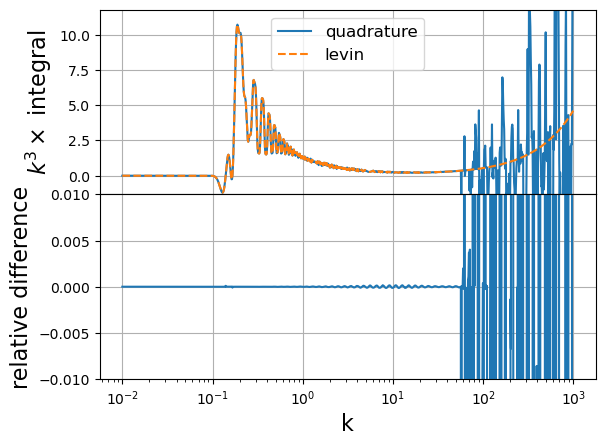

In [11]:
x_length = 100
N = 2
x = np.geomspace(1e-5,100,x_length) #define support
y = np.linspace(1,2, N) 

f_of_x = x[:,None]**(3*y[None,:]) + (x**2 +x)[:, None] #define integrands f(x) 

integral_type = 4 
N_thread = 8 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
lp_triple = levin.pylevin(integral_type, x, f_of_x, logx, logy, N_thread) #Constructor of the class

n_sub = 6 #number of collocation points in each bisection
n_bisec_max = 96 #maximum number of bisections used
rel_acc = 0 #relative accuracy target
boost_bessel = True #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?
lp_triple.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)

M = 1000
k = np.geomspace(1e-2,1000,M)
ell_1 = (5*np.ones_like(k)).astype(int)
ell_2 = (10*np.ones_like(k)).astype(int)
ell_3 = (15*np.ones_like(k)).astype(int)

t0 = time.time()
lp_triple.levin_integrate_bessel_triple(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,k,ell_1,ell_2,ell_3, result_levin)
print("Levin took", time.time() -t0, "s")

t0 = time.time()
for k_i, k_val in enumerate(k):
    for i_integral in range(N):
        integrand_quad = lambda xquad: ((xquad**(3*y[i_integral]) + xquad**2 + xquad)*spherical_jn(ell_1[0],k_val*xquad) * spherical_jn(ell_2[0],k_val*xquad)* spherical_jn(ell_3[0],k_val*xquad))
        quad_result[k_i, i_integral] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4, limit = 1000)[0]
print("Quadrature took", time.time() -t0, "s")

fig, ax = plt.subplots(2)#
ax[0].semilogx(k,quad_result[:,0]*k**3, label = r"quadrature")
ax[0].semilogx(k,result_levin[:,0]*k**3, ls = "--", label = r"levin")
ax[0].set_ylabel(r"$k^3 \times$ integral", fontsize = 16)
ax[0].grid(axis = "both")
ax[0].legend(fontsize = 12)
ax[0].set_ylim(1.1*np.min(result_levin[:,0]*k**3),1.1*np.max(result_levin[:,0]*k**3))


ax[1].semilogx(k, (quad_result[:,0] - result_levin[:,0])/result_levin[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-.01,.01)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)

# Using only the diagonals of integrands and parameters

It is possible to calculate only the diagonals of the specified integrands and the given parameters. For this purpose, suppose we have the integral:

$$ I(y) = \int_a^b j_\ell(xy) f(x,y) \mathrm{d}x\,. $$

Now we would, as before specify the integrand by providing $f(x,y)$ as before, but this time for 2000 values of $y$:

In [41]:
x_length = 100
N = 2000
x = np.geomspace(1e-5,100,x_length) #define support
y = np.geomspace(1e-2,1e3, N) 
f_of_x = x[:,None]**3*y[None,:] + (x**2 +x)[:, None] #define integrands f(x) 

So here we look at the following integrand:

$$
f(x,y) = x^3*y + x^2 + x\;,
$$

If we would simply initialise ``pylevin`` and call the integral for ``y`` as before, we would calculate ``(N,N)``, although we only want the diagonal of this matrix. The way around is to tell ``pylevin`` to only calculate the diagonals. This is done by setting the last argument of the constructor to ``True``. Since the default value is ``False`` we didn't need to take care of this before.

In [42]:
integral_type = 0 
N_thread = 1 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
diagonal = True
lp_single = levin.pylevin(integral_type, x, f_of_x, logx, logy, N_thread, diagonal) #Constructor of the class

n_sub = 10 #number of collocation points in each bisection
n_bisec_max = 32 #maximum number of bisections used
rel_acc = 1e-4 #relative accuracy target
boost_bessel = True #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?
lp_single.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)

When using the diagonals only, we expect only ``N`` results. Therefore, when allocating the corresponding result, we also only allocate a one-dimensional array with length ``N``. Otherwise, everything else stays the same as before.

In [53]:
M = N #number of arguments at which the integrals are evaluated
k = np.copy(y)
ell = (5*np.ones_like(k)).astype(int) #order of the Bessel function, needs to be an integer
t0 = time.time()
result_levin = np.zeros(N) #allocate the result
lp_single.levin_integrate_bessel_single(x[0]*np.ones_like(k), x[-1]*np.ones_like(k), k, ell, result_levin)
print("Levin took", time.time() -t0, "s")


Levin took 0.029665708541870117 s


/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_90844/2280511071.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_result[k_i] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_90844/2280511071.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_result[k_i] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]


Quadrature took 2.488179922103882 s


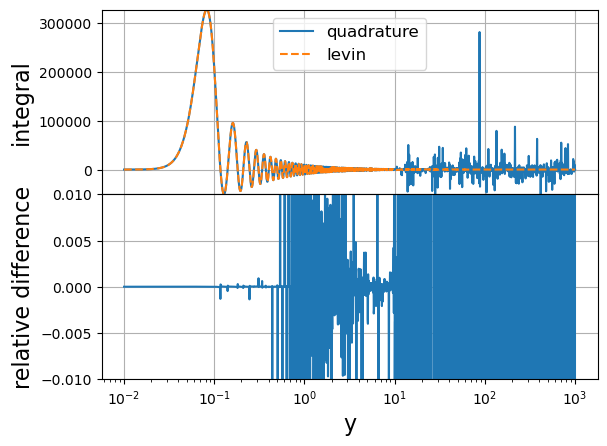

In [54]:
from scipy.special import spherical_jn, jv
from scipy import integrate


quad_result = np.zeros_like(result_levin)

t0 = time.time()
for k_i, k_val in enumerate(y):
    integrand_quad = lambda xquad: ((xquad**3*y[k_i] + xquad**2 + xquad)*spherical_jn(ell[0],k_val*xquad))
    quad_result[k_i] = integrate.quad(integrand_quad, x[0], x[-1], epsabs=0, epsrel = 1e-4)[0]
print("Quadrature took", time.time() -t0, "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(y,quad_result[:], label = r"quadrature")
ax[0].semilogx(y,result_levin[:], ls = "--", label = r"levin")
ax[0].set_ylabel(r"integral", fontsize = 16)
ax[0].grid(axis = "both")
ax[0].legend(fontsize = 12)
ax[0].set_ylim(np.min(result_levin),np.max(result_levin))


ax[1].semilogx(y, (quad_result - result_levin)/result_levin)
ax[1].set_xlabel("y", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-.01,.01)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)
